In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import tweepy
import time
import pandas as pd
import json
import csv
import preprocessor as p
import numpy as np

## Data Wrangling

In [3]:
df = pd.read_csv('PlantBased_Tweets.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_at      10000 non-null  object
 1   tweet_id        10000 non-null  int64 
 2   screen_name     10000 non-null  object
 3   text            9952 non-null   object
 4   favorite_count  10000 non-null  int64 
 5   retweet_count   10000 non-null  int64 
 6   hashtags        10000 non-null  object
dtypes: int64(3), object(4)
memory usage: 547.0+ KB


In [5]:
# look for duplicates
sum(df.duplicated())

4658

In [6]:
# dropping duplicate 
df = df.drop_duplicates(keep='first')
print('Plant-Based DataFrame:\n', df)

Plant-Based DataFrame:
                           created_at             tweet_id      screen_name  \
0     Thu Nov 05 05:13:04 +0000 2020  1324218150620221440       CraftyBoi_   
1     Thu Nov 05 05:06:42 +0000 2020  1324216547565432832            VASSY   
2     Thu Nov 05 05:03:08 +0000 2020  1324215650433249281  1BarbaraShannon   
3     Thu Nov 05 05:02:43 +0000 2020  1324215547387523072    roseannebyrne   
4     Thu Nov 05 05:01:17 +0000 2020  1324215184769114112  itsallurasworld   
...                              ...                  ...              ...   
9995  Sun Nov 01 16:47:24 +0000 2020  1322943332213944325      AlanZweibel   
9996  Sun Nov 01 16:46:55 +0000 2020  1322943212462526464    snehaspurohit   
9997  Sun Nov 01 16:46:44 +0000 2020  1322943166367105024    KatePichowicz   
9998  Sun Nov 01 16:46:32 +0000 2020  1322943117247442944    DamianRinaldi   
9999  Sun Nov 01 16:46:18 +0000 2020  1322943055448756230       mygreenpod   

                                       

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5342 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   created_at      5342 non-null   object
 1   tweet_id        5342 non-null   int64 
 2   screen_name     5342 non-null   object
 3   text            5313 non-null   object
 4   favorite_count  5342 non-null   int64 
 5   retweet_count   5342 non-null   int64 
 6   hashtags        5342 non-null   object
dtypes: int64(3), object(4)
memory usage: 333.9+ KB


In [8]:
tweet_df = df[['text']]

In [9]:
# apply the first round of text cleaning techniques
import re
import string

def clean_text(text):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', text)

    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    
    # remove triple dots
    text = re.sub("\.\.\.", "", text)
    
    # strip punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)

    # Remove single characters from the start
    text = re.sub(r'\^[a-zA-Z]\s+', ' ', text) 

    # Substituting multiple spaces with single space
    text = re.sub(r'\s+', ' ', text, flags=re.I)

    # Removing prefixed 'b'
    text = re.sub(r'^b\s+', '', text)
    
    # Remove leading and trailing whitespaces
    text = re.sub(r'^\s+|\s+$', '', text)
    
    # Remove numbers
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", " ", text)

    # Converting to Lowercase
    text = text.lower()
    
    return text

round1 = lambda x: clean_text(x) 

tweet_df.text = tweet_df.text.astype(str)

# take a look at the updated text
tweets = pd.DataFrame(tweet_df['text'].apply(round1))
tweets

C:\Users\vungu\Anaconda3\lib\site-packages\pandas\core\generic.py:5159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,text
0,do you have plant based diet
1,no ate indian and then after it for dessert ha...
2,ceo brings her values to work we re mission wi...
3,i eat plant based eat plant based eat plant ba...
4,i think wanna go plant based pescatarian meat ...
...,...
9995,jeremy here the bad news about year ago my wif...
9996,if every single one of us who has compassion t...
9997,if youre ever in london cant recommend this pl...
9998,here are the top trends in and desserts


In [10]:
nan_value = float("NaN")

#Convert NaN values to empty string
tweets.replace("", nan_value, inplace=True)
tweets.dropna(subset = ["text"], inplace=True)
tweets.reset_index(drop=True, inplace=True)
tweets = tweets.sort_index(ascending=False)
tweets.head()

,text
5340,study quantifies game changing environmental e...
5339,here are the top trends in and desserts
5338,if youre ever in london cant recommend this pl...
5337,if every single one of us who has compassion t...
5336,jeremy here the bad news about year ago my wif...


In [11]:
tweets.shape

(5341, 1)

In [12]:
tweets.describe()

,text
count,5341
unique,4595
top,plant based diets may lower blood pressure num...
freq,140


In [22]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')   
# define stop words
nltk.download('stopwords') 
stop_words = nltk.corpus.stopwords.words('english')
#add words that aren't in the NLTK stopwords list
new_stopwords = ['plant-based', 'plant based', 'plant', 'based']
stop_words.extend(new_stopwords)
print(len(stop_words))
print(stop_words)

183
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vungu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vungu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
def fix_Text2(text):
    letters_only = re.sub("[^a-zA-Z]"," ", str(text))
    words=letters_only.lower().split()
    meaningful=[WordNetLemmatizer().lemmatize(word) for word in words if word not in stop_words]
    return(" ".join(meaningful))

num_resp = tweets["text"].size   #df
clean_description_lemmization = []     #clean_

for i in range(0,num_resp):
    clean_description_lemmization.append(fix_Text2(tweets["text"][i])) #clean_

clean_description_lemmization[0:10]    ## clean_

['diet',
 'ate indian dessert oreo cooky oh',
 'ceo brings value work mission company compassionate leadership',
 'eat eat eat dammit',
 'think wanna go pescatarian meat starting gross',
 'new lifestyle long time vegan gone day slim picking delectable dessert',
 'best busting food also fit diet including vegan meal plan',
 'honestly protein taste like as dont recommend',
 'meat quite impressed way impossible beef join whip impossible beef',
 'almost month amp made best food cant take away sushi tho']

In [24]:
len(clean_description_lemmization)

5341

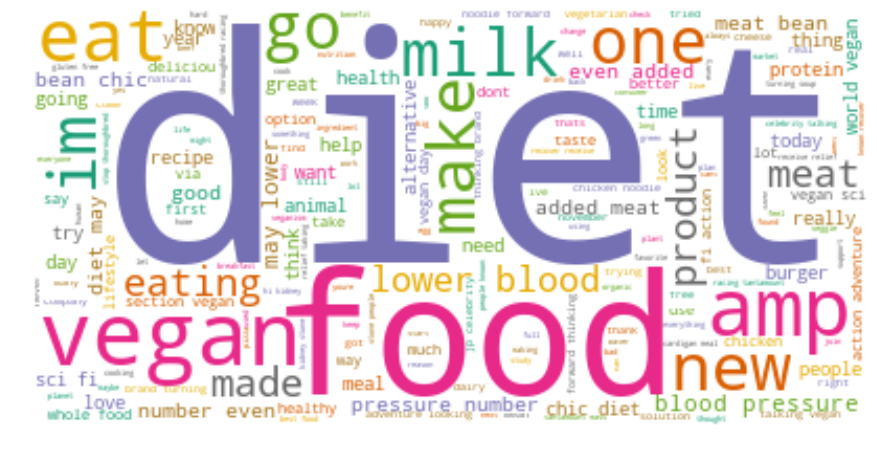

In [25]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt

# word cloud
text_wc = " ".join(item for item in clean_description_lemmization)    #clean_
wordcloud = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=1).generate(text_wc)

plt.figure(figsize = (15, 20))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv=TfidfVectorizer() 
tv_transform=tv.fit_transform(clean_description_lemmization)
# transfer to an array
tv_array = tv_transform.toarray()
tv_transform.shape

(5341, 7894)

In [27]:
tv_df = pd.DataFrame(tv_array, columns=tv.get_feature_names())
tv_df.head()

,aa,aaa,aaaaaa,aaad,ab,abandon,abbeywood,abc,abe,abigail,...,zel,zero,zhengting,zimchem,zinc,zine,ziyi,zone,zurlos,zweibr
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
from scipy.cluster.vq import kmeans,vq
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from sklearn.metrics import silhouette_score
%matplotlib inline


sse1 = {}
silhouette1 = {}


for k in range(2,20):
  km = KMeans(n_clusters=k, max_iter=1000, verbose = 0).fit(tv_array)
  sse1[k] = km.inertia_
  #FOLLOWING LINE CAUSES ERROR
  silhouette1[k] = silhouette_score(tv_array, km.labels_, metric='euclidean')

best_cluster_size = 1
min_error = float("inf")

for cluster_size in sse1:
    if sse1[cluster_size] < min_error:
        min_error = sse1[cluster_size]
        best_cluster_size = cluster_size

print(sse1)
print("====")
print(silhouette1)

{2: 5134.496036229414, 3: 5090.976075700752, 4: 5054.046355820219, 5: 5010.259618634725, 6: 5010.14912351381, 7: 4974.047438535704, 8: 4956.172892876393, 9: 4937.612662580668, 10: 4886.308903462669, 11: 4901.995537450618, 12: 4869.798433011796, 13: 4830.872094136177, 14: 4843.614709751311, 15: 4801.635974363456, 16: 4787.196109891447, 17: 4793.842443990804, 18: 4766.917948082087, 19: 4757.07006080946, 20: 4728.162290428005, 21: 4730.239514548071, 22: 4725.849517611302, 23: 4695.808562681472, 24: 4699.688202897664, 25: 4686.027801590889, 26: 4689.116256044874, 27: 4655.238576634929, 28: 4637.075042731137, 29: 4636.575070460325, 30: 4633.0126410294815, 31: 4615.783604565381, 32: 4618.957729772412, 33: 4637.276801665613, 34: 4594.252325300789, 35: 4596.073761996268, 36: 4592.35599516463, 37: 4589.989121054512, 38: 4589.025848373699, 39: 4553.564305182382, 40: 4567.227829233652, 41: 4558.237094100552, 42: 4519.960917913577, 43: 4537.236770800714, 44: 4520.8162385186515}
====
{2: 0.02594136

In [29]:
from tqdm import tqdm

def finding_num_cluster(X, min_clusters =2, max_clusters =20):
    silh = []
    inertia = []
    clusters = range(min_clusters,max_clusters)
    for n in tqdm(clusters):

        model = KMeans(n_clusters = n, random_state=0)
        preds = model.fit_predict(X)

        silhouette_avg = silhouette_score(X, preds)

        silh.append(silhouette_avg)
        inertia.append(model.inertia_)

    fig, (ax1,ax2) = plt.subplots(2,1, sharex=False, figsize=(8,7))
    ax1.plot(clusters, silh,marker="o")
    ax1.set_ylabel("Silhoutte Score")
    ax1.set_xlabel('number of clusters')
    ax2.plot(clusters, inertia, marker="x")
    ax2.set_ylabel("Inertia (SSE)")
    ax2.set_xlabel("number of clusters")
    plt.show()

100%|██████████| 18/18 [18:16<00:00, 60.89s/it]


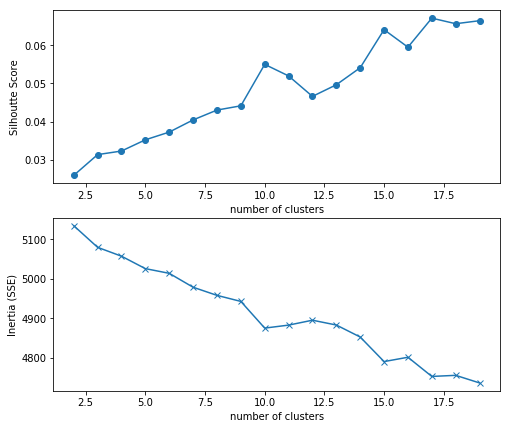

In [30]:
finding_num_cluster(tv_array)

In [31]:
from scipy.cluster.vq import kmeans,vq

In [32]:
tv=TfidfVectorizer(max_features=100)  # 1.change # of features 2.maybe min_df
tv_transform=tv.fit_transform(clean_description_lemmization)

In [63]:
four_clusters=4
cluster_centers4,distortion4=kmeans(tv_transform.todense(),four_clusters)

tv4=TfidfVectorizer(max_features=100)  # 1.change # of features 2.maybe min_df
tv4_transform=tv4.fit_transform(clean_description_lemmization)

terms4=tv4.get_feature_names()
for i in range(four_clusters):
    center_terms=dict(zip(terms4,list(cluster_centers4[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:3])

['diet', 'meat', 'lower']
['amp', 'protein', 'like']
['food', 'whole', 'eat']
['vegan', 'celebrity', 'world']


In [64]:
tv5=TfidfVectorizer(max_features=100) 
tv5_transform=tv5.fit_transform(clean_description_lemmization)

five_clusters=5  
cluster_centers5,distortion5=kmeans(tv5_transform.todense(),five_clusters)

terms5=tv5.get_feature_names()
for i in range(five_clusters):
    center_terms=dict(zip(terms5,list(cluster_centers5[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:3])

['vegan', 'celebrity', 'world']
['animal', 'day', 'today']
['diet', 'meat', 'amp']
['blood', 'pressure', 'lower']
['food', 'whole', 'eat']


In [65]:
tv6=TfidfVectorizer(max_features=100) 
tv6_transform=tv6.fit_transform(clean_description_lemmization)

six_clusters=6  
cluster_centers6,distortion6=kmeans(tv6_transform.todense(),six_clusters)

terms6=tv6.get_feature_names()
for i in range(six_clusters):
    center_terms=dict(zip(terms6,list(cluster_centers6[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:3])

['amp', 'protein', 'vegan']
['diet', 'vegan', 'know']
['im', 'going', 'diet']
['meat', 'diet', 'eating']
['blood', 'pressure', 'lower']
['vegan', 'food', 'milk']


In [66]:
tv7=TfidfVectorizer(max_features=100) 
tv7_transform=tv7.fit_transform(clean_description_lemmization)

seven_clusters=7  # change the # of clusters
cluster_centers7,distortion7=kmeans(tv7_transform.todense(),seven_clusters)

terms7=tv7.get_feature_names()
for i in range(seven_clusters):
    center_terms=dict(zip(terms7,list(cluster_centers7[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:3])

['meat', 'amp', 'protein']
['recipe', 'dinner', 'vegan']
['diet', 'lower', 'blood']
['food', 'whole', 'eat']
['like', 'im', 'burger']
['love', 'health', 'much']
['vegan', 'celebrity', 'world']


In [67]:
tv8=TfidfVectorizer(max_features=100) 
tv8_transform=tv8.fit_transform(clean_description_lemmization)

eight_clusters=8  
cluster_centers8,distortion8=kmeans(tv8_transform.todense(),eight_clusters)

terms8=tv8.get_feature_names()
for i in range(eight_clusters):
    center_terms=dict(zip(terms8,list(cluster_centers8[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:3])

['milk', 'dairy', 'made']
['vegan', 'celebrity', 'world']
['amp', 'protein', 'healthy']
['natural', 'help', 'vegan']
['blood', 'pressure', 'lower']
['want', 'go', 'really']
['diet', 'food', 'meat']
['people', 'diet', 'many']


In [49]:
tv_bi4=TfidfVectorizer(max_features=100,ngram_range=(2,2)) 
tv_bi4_transform=tv_bi4.fit_transform(clean_description_lemmization)

terms_bi4=tv_bi4.get_feature_names()

for i in range(four_clusters):
    center_terms=dict(zip(terms_bi4,list(cluster_centers4[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:3])

['chef host', 'special event', 'thinking brand']
['blender month', 'review learn', 'new restaurant']
['vegan day', 'cardigan meal', 'win america']
['eating meat', 'food eat', 'pressure number']


In [50]:
tv_bi5=TfidfVectorizer(max_features=100,ngram_range=(2,2)) 
tv_bi_transform5=tv_bi5.fit_transform(clean_description_lemmization)

terms_bi5=tv_bi5.get_feature_names()

for i in range(five_clusters):
    center_terms=dict(zip(terms_bi5,list(cluster_centers5[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:3])

['brand turning', 'back menu', 'food eat']
['stone people', 'flavour packed', 'stop thoroughbred']
['food eat', 'pressure number', 'amp pure']
['vegan day', 'cardigan meal', 'win america']
['eating meat', 'pressure number', 'new restaurant']


In [51]:
tv_bi6=TfidfVectorizer(max_features=100,ngram_range=(2,2)) 
tv_bi_transform6=tv_bi6.fit_transform(clean_description_lemmization)

terms_bi6=tv_bi6.get_feature_names()

for i in range(six_clusters):
    center_terms=dict(zip(terms_bi6,list(cluster_centers6[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:3])

['vegan day', 'cardigan meal', 'win america']
['stone people', 'flavour packed', 'stop thoroughbred']
['protein powder', 'crystal cell', 'ninja blender']
['eating meat', 'host special', 'vegan day']
['pressure number', 'amp pure', 'sci fi']
['food eat', 'whole food', 'event celebrate']


In [52]:
tv_bi7=TfidfVectorizer(max_features=100,ngram_range=(2,2)) 
tv_bi7_transform=tv_bi7.fit_transform(clean_description_lemmization)

terms=tv_bi7.get_feature_names()
for i in range(seven_clusters):
    center_terms=dict(zip(terms,list(cluster_centers7[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:3])

['eating meat', 'vegan day', 'look like']
['vegan day', 'cardigan meal', 'win america']
['pressure number', 'ffls healthy', 'meat bean']
['food eat', 'whole food', 'event celebrate']
['brand turning', 'world vegan', 'taking crystal']
['amp pure', 'sci fi', 'protein powder']
['blender month', 'review learn', 'new restaurant']


In [53]:
tv_bi8=TfidfVectorizer(max_features=100,ngram_range=(2,2)) 
tv_bi8_transform=tv_bi8.fit_transform(clean_description_lemmization)

terms_bi8=tv_bi8.get_feature_names()

for i in range(eight_clusters):
    center_terms=dict(zip(terms_bi8,list(cluster_centers8[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:3])

['food eat', 'meat bean', 'kidney stone']
['pressure number', 'ffls healthy', 'meat bean']
['protein powder', 'crystal cell', 'ninja blender']
['read review', 'gluten free', 'vegan day']
['amp pure', 'sci fi', 'food eat']
['simple flavour', 'eu put', 'vegan day']
['vegan day', 'cardigan meal', 'win america']
['eating meat', 'new restaurant', 'blender month']


In [55]:
tv_ub4=TfidfVectorizer(max_features=100,ngram_range=(1,2)) 
tvub4_transform=tv_ub4.fit_transform(clean_description_lemmization)

four_clusters=4 # change the # of clusters
cluster_centers4ub,distortion4ub=kmeans(tvub4_transform.todense(),four_clusters)

terms_ub4=tv_ub4.get_feature_names()
for i in range(four_clusters):
    center_terms=dict(zip(terms_ub4,list(cluster_centers4ub[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:7])

['diet', 'vegan', 'know', 'eat', 'meat', 'amp', 'health']
['food', 'whole', 'eat', 'vegan', 'best', 'say', 'diet']
['meat', 'amp', 'like', 'protein', 'milk', 'im', 'new']
['vegan', 'world', 'world vegan', 'day', 'recipe', 'adventure', 'section']


In [56]:
tv_ub5=TfidfVectorizer(max_features=100,ngram_range=(1,2)) 
tvub5_transform=tv_ub5.fit_transform(clean_description_lemmization)

five_clusters=5 # change the # of clusters
cluster_centers5ub,distortion5ub=kmeans(tvub5_transform.todense(),five_clusters)

terms_ub5=tv_ub5.get_feature_names()
for i in range(five_clusters):
    center_terms=dict(zip(terms_ub5,list(cluster_centers5ub[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:7])

['vegan', 'diet', 'food', 'world', 'eat', 'whole', 'day']
['sci', 'sci fi', 'fi', 'vegan sci', 'section vegan', 'section', 'action adventure']
['amp', 'protein', 'healthy', 'vegan', 'food', 'month', 'diet']
['may lower', 'pressure number', 'blood pressure', 'lower blood', 'added meat', 'diet may', 'even added']
['meat', 'like', 'milk', 'protein', 'im', 'meal', 'new']


In [57]:
tv_ub7=TfidfVectorizer(max_features=100,ngram_range=(1,2)) 
tvub7_transform=tv_ub7.fit_transform(clean_description_lemmization)

seven_clusters=7 # change the # of clusters
cluster_centers7ub,distortion7ub=kmeans(tvub7_transform.todense(),seven_clusters)

terms_ub7=tv_ub7.get_feature_names()
for i in range(seven_clusters):
    center_terms=dict(zip(terms_ub7,list(cluster_centers7ub[i])))
    sorted_terms=sorted(center_terms,key=center_terms.get,reverse=True)
    print(sorted_terms[:7])

['amp', 'protein', 'milk', 'like', 'new', 'meal', 'recipe']
['sci', 'sci fi', 'fi', 'vegan sci', 'section vegan', 'section', 'action adventure']
['food', 'whole', 'eat', 'vegan', 'best', 'say', 'diet']
['diet', 'meat', 'lower', 'blood pressure', 'blood', 'pressure', 'may lower']
['would', 'stop', 'make', 'diet', 'want', 'one', 'like']
['vegan', 'world', 'world vegan', 'recipe', 'day', 'diet', 'know']
['im', 'people', 'go', 'diet', 'going', 'meat', 'like']


In [58]:
columns=tv.get_feature_names() # feature names
#transform to DF
df_description=pd.DataFrame(tv_transform.toarray(),columns=columns) #df_
# insepct transformation
tv_sum=df_description.sum() #df

tv_sum.sort_values(ascending=False).head(20)

diet       334.451042
vegan      326.959004
food       259.942139
meat       223.066671
amp        158.094263
like       140.543396
protein    134.749704
new        122.330676
eat        117.377619
im         115.535958
recipe     114.398772
milk       114.026515
eating     101.135923
go         101.112391
one         99.223496
meal        98.680020
burger      98.103717
get         97.437932
make        95.033115
people      94.572386
dtype: float64

In [60]:
df_sum=pd.DataFrame(tv_sum,columns=['importance']).sort_values(by='importance',ascending=False).iloc[:15]

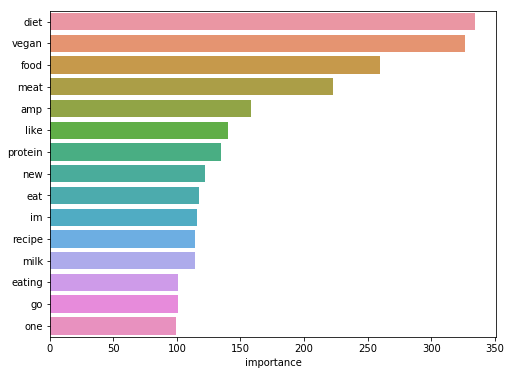

In [61]:
plt.figure(figsize=(8,6))
sns.barplot(x=df_sum.importance, y=df_sum.index, orient ='h', label='importance')

In [68]:
columns7=tv.get_feature_names() # feature names
#transform to DF
df_description7=pd.DataFrame(tv7_transform.toarray(),columns=columns7) #df_
# insepct transformation
tv7_sum=df_description7.sum() #df

tv7_sum.sort_values(ascending=False).head(20)

diet       334.451042
vegan      326.959004
food       259.942139
meat       223.066671
amp        158.094263
like       140.543396
protein    134.749704
new        122.330676
eat        117.377619
im         115.535958
recipe     114.398772
milk       114.026515
eating     101.135923
go         101.112391
one         99.223496
meal        98.680020
burger      98.103717
get         97.437932
make        95.033115
people      94.572386
dtype: float64

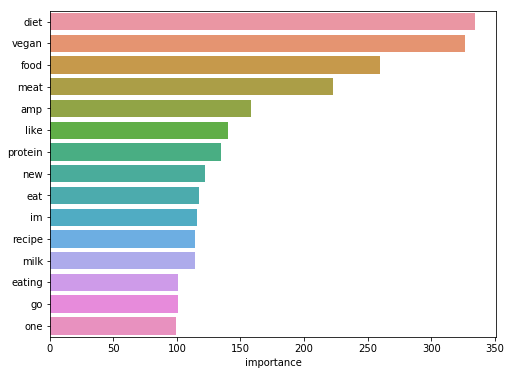

In [69]:
df7_sum=pd.DataFrame(tv7_sum,columns=['importance']).sort_values(by='importance',ascending=False).iloc[:15]

plt.figure(figsize=(8,6))
sns.barplot(x=df7_sum.importance, y=df7_sum.index, orient ='h', label='importance')

In [70]:
columns7bi=tv_bi7.get_feature_names() # feature names
#transform to DF
df_description7bi=pd.DataFrame(tv_bi7_transform.toarray(),columns=columns7bi) #df_
# insepct transformation
tv7bi_sum=df_description7bi.sum() #df

tv7bi_sum.sort_values(ascending=False).head(20)

whole food          54.878058
world vegan         51.661960
blood pressure      47.323952
lower blood         47.323952
pressure number     45.112449
may lower           45.112449
number even         44.679079
diet may            44.679079
added meat          44.679079
even added          44.679079
bean chic           44.392554
meat bean           44.392554
vegan day           39.868606
cardigan meal       38.000000
sci fi              33.298152
section vegan       30.522793
vegan sci           29.599729
action adventure    29.096398
fi action           29.096398
gluten free         28.772944
dtype: float64

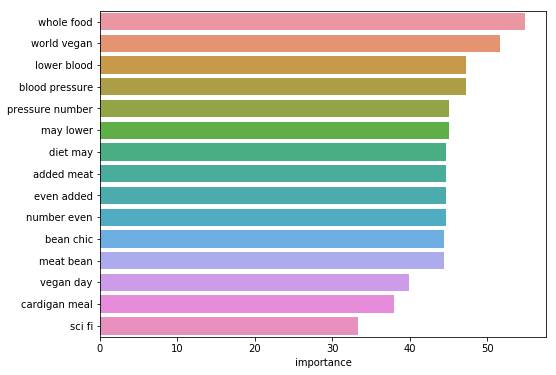

In [71]:
df7bi_sum=pd.DataFrame(tv7bi_sum,columns=['importance']).sort_values(by='importance',ascending=False).iloc[:15]

plt.figure(figsize=(8,6))
sns.barplot(x=df7bi_sum.importance, y=df7bi_sum.index, orient ='h', label='importance')

In [72]:
columns7ub=tv_ub7.get_feature_names() # feature names
#transform to DF
df_description7ub=pd.DataFrame(tvub7_transform.toarray(),columns=columns7ub) #df_
# insepct transformation
tv7ub_sum=df_description7ub.sum() #df

tv7ub_sum.sort_values(ascending=False).head(20)

vegan      365.845046
diet       336.556417
food       274.083054
meat       220.879714
amp        168.639838
like       151.095735
protein    137.235131
new        131.201981
recipe     122.720458
eat        121.219542
im         120.734369
milk       116.897988
meal       110.603716
eating     107.662859
go         105.384662
one        102.395345
burger     100.855407
get        100.625804
make        98.739236
made        97.961363
dtype: float64

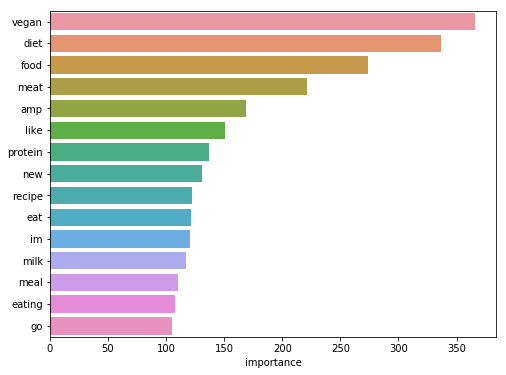

In [73]:
df7ub_sum=pd.DataFrame(tv7ub_sum,columns=['importance']).sort_values(by='importance',ascending=False).iloc[:15]

plt.figure(figsize=(8,6))
sns.barplot(x=df7ub_sum.importance, y=df7ub_sum.index, orient ='h', label='importance')

In [74]:
from textblob import TextBlob

# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
tweets['Subjectivity'] = tweets['text'].apply(getSubjectivity)
tweets['Polarity'] = tweets['text'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
tweets

,text,Subjectivity,Polarity
5340,study quantifies game changing environmental e...,0.400000,-0.400000
5339,here are the top trends in and desserts,0.500000,0.500000
5338,if youre ever in london cant recommend this pl...,0.400000,0.500000
5337,if every single one of us who has compassion t...,0.157143,0.064286
5336,jeremy here the bad news about year ago my wif...,0.666667,-0.700000
...,...,...,...
4,i think wanna go plant based pescatarian meat ...,0.050000,0.000000
3,i eat plant based eat plant based eat plant ba...,0.000000,0.000000
2,ceo brings her values to work we re mission wi...,0.000000,0.000000
1,no ate indian and then after it for dessert ha...,0.000000,0.000000


In [75]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

tweets['Analysis'] = tweets.Polarity.apply(getAnalysis)

tweets

,text,Subjectivity,Polarity,Analysis
5340,study quantifies game changing environmental e...,0.400000,-0.400000,Negative
5339,here are the top trends in and desserts,0.500000,0.500000,Positive
5338,if youre ever in london cant recommend this pl...,0.400000,0.500000,Positive
5337,if every single one of us who has compassion t...,0.157143,0.064286,Positive
5336,jeremy here the bad news about year ago my wif...,0.666667,-0.700000,Negative
...,...,...,...,...
4,i think wanna go plant based pescatarian meat ...,0.050000,0.000000,Neutral
3,i eat plant based eat plant based eat plant ba...,0.000000,0.000000,Neutral
2,ceo brings her values to work we re mission wi...,0.000000,0.000000,Neutral
1,no ate indian and then after it for dessert ha...,0.000000,0.000000,Neutral


In [76]:
# print all positive tweets
print('Positive tweets:\n')
j=1
sortedDf = tweets.sort_values(by=['Polarity'])
for i in range(0, sortedDf.shape[0]):
    if(sortedDf['Analysis'][i] == 'Positive'):
        print(str(j) + '. ' + sortedDf['text'][i])
        print()
        j+=1

Positive tweets:

1. new to the plant based lifestyle or long time vegan gone are the days of slim pickings for delectable desserts

2. some of the best busting foods also fit in plant based diet including vegan meal plan

3. honestly this plant based protein taste like ass dont recommend

4. been almost plant based for months amp have made and had some of the best food cant take away my sushi tho

5. as long as we dont have the full az count can still throw my plant based pizza in the oven right

6. vega sport protein its plant based and tasted soooo good buy the chocolate flavor and use water to m

7. today we welcome tennessee titans linebacker amp plant based chef to our fam as official beyond

8. plant based dinners are easy with read my review to learn more

9. hey folks its the holiday season so im going to be making plant based versions of my favorite dishes growing up w

10. ah shit and almost forgot been vegan well plant based for the past almost months its cool the food good

In [77]:
# print all negative tweets
print('Negative tweets:\n')
j=1
sortedDf = tweets.sort_values(by=['Polarity'])
for i in range(0, sortedDf.shape[0]):
    if(sortedDf['Analysis'][i] == 'Negative'):
        print(str(j) + '. ' + sortedDf['text'][i])
        print()
        j+=1

Negative tweets:

1. no plant based meat quite impressed me the way this impossible beef has join me as whip up an impossible beef

2. countries like india have heaps of poor farmers whose only non vegan consumption is milk but their weekly

3. theres plant based chicken its not the real deal but

4. is it real chicken or plant based chicken

5. considering cutting conventional dairy out of my diet but plant based cheese is not the move on texture

6. netherlands based firm nexusnovus wins contract to set up integrated solid waste management plant at bial

7. plant based will do that fuck keto try it for one week if you dont like how you feel or look so something different

8. noplant basedwhy something that requires animal exploitation when the other option which is al

9. i set new routines plant based diet and food diary ive done both on and off before lets see how long ill keeping them up this time

10. i wanna go plant based so bad

11. armaments he tend to use include redwood arm

In [78]:
# Print the percentage of positive tweets
ptweets = tweets[tweets.Analysis == 'Positive']
ptweets = ptweets['text']
ptweets

round( (ptweets.shape[0] / tweets.shape[0]) * 100 , 1)

46.6

In [79]:
# Print the percentage of negative tweets
negtweets = tweets[tweets.Analysis == 'Negative']
negtweets = negtweets['text']
negtweets

round( (negtweets.shape[0] / tweets.shape[0]) * 100 , 1)

13.6

In [80]:
# Print the percentage of neutral tweets
neutweets = tweets[tweets.Analysis == 'Neutral']
neutweets = neutweets['text']
neutweets

round( (neutweets.shape[0] / tweets.shape[0]) * 100 , 1)

39.8

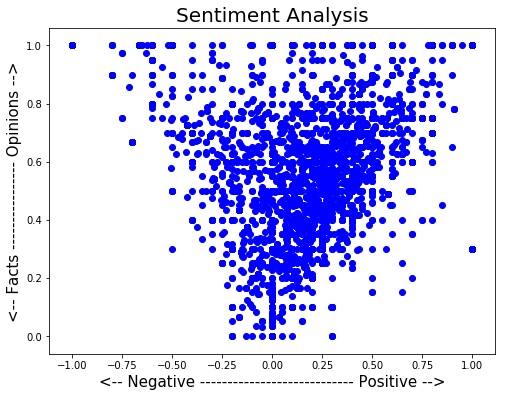

In [81]:
import matplotlib.pyplot as plt

# Plotting 
plt.figure(figsize=(8,6)) 
for i in range(0, tweets.shape[0]):
  plt.scatter(tweets["Polarity"][i], tweets["Subjectivity"][i], color='Blue') 

# plt.scatter(x,y,color)   
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative ---------------------------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts ---------------- Opinions -->', fontsize=15) 
plt.show()

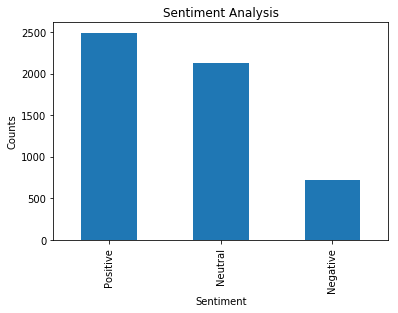

In [82]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
tweets['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

In [29]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
  
stop_words = set(stopwords.words('english')) 

word_tokens = word_tokenize(str(tweets.text)) 
  
filtered_sentence = [w for w in word_tokens if not w in stop_words] 
  
filtered_sentence = [] 
  
for w in word_tokens: 
    if w not in stop_words: 
        filtered_sentence.append(w) 

print(word_tokens) 
print('------------------------------------------')
print(filtered_sentence) 

['5340', 'study', 'quantifies', 'game', 'changing', 'environmental', 'e', '...', '5339', 'here', 'are', 'the', 'top', 'trends', 'in', 'and', 'desserts', '5338', 'if', 'youre', 'ever', 'in', 'london', 'cant', 'recommend', 'this', 'pl', '...', '5337', 'if', 'every', 'single', 'one', 'of', 'us', 'who', 'has', 'compassion', 't', '...', '5336', 'jeremy', 'here', 'the', 'bad', 'news', 'about', 'year', 'ago', 'my', 'wif', '...', '...', '4', 'i', 'think', 'wan', 'na', 'go', 'plant', 'based', 'pescatarian', 'meat', '...', '3', 'i', 'eat', 'plant', 'based', 'eat', 'plant', 'based', 'eat', 'plant', 'ba', '...', '2', 'ceo', 'brings', 'her', 'values', 'to', 'work', 'we', 're', 'mission', 'wi', '...', '1', 'no', 'ate', 'indian', 'and', 'then', 'after', 'it', 'for', 'dessert', 'ha', '...', '0', 'do', 'you', 'have', 'plant', 'based', 'diet', 'Name', ':', 'text', ',', 'Length', ':', '5341', ',', 'dtype', ':', 'object']
------------------------------------------
['5340', 'study', 'quantifies', 'game', '

In [30]:
from nltk.stem import WordNetLemmatizer
set(stopwords.words('english'))

lemma_word = []
wordnet_lemmatizer = WordNetLemmatizer()
for s in filtered_sentence:
    word1 = wordnet_lemmatizer.lemmatize(s, pos = "n")
    word2 = wordnet_lemmatizer.lemmatize(word1, pos = "v")
    word3 = wordnet_lemmatizer.lemmatize(word2, pos = ("a"))
    lemma_word.append(word3)
print(lemma_word)

['5340', 'study', 'quantify', 'game', 'change', 'environmental', 'e', '...', '5339', 'top', 'trend', 'dessert', '5338', 'youre', 'ever', 'london', 'cant', 'recommend', 'pl', '...', '5337', 'every', 'single', 'one', 'u', 'compassion', '...', '5336', 'jeremy', 'bad', 'news', 'year', 'ago', 'wif', '...', '...', '4', 'think', 'wan', 'na', 'go', 'plant', 'base', 'pescatarian', 'meat', '...', '3', 'eat', 'plant', 'base', 'eat', 'plant', 'base', 'eat', 'plant', 'ba', '...', '2', 'ceo', 'bring', 'value', 'work', 'mission', 'wi', '...', '1', 'eat', 'indian', 'dessert', 'ha', '...', '0', 'plant', 'base', 'diet', 'Name', ':', 'text', ',', 'Length', ':', '5341', ',', 'dtype', ':', 'object']


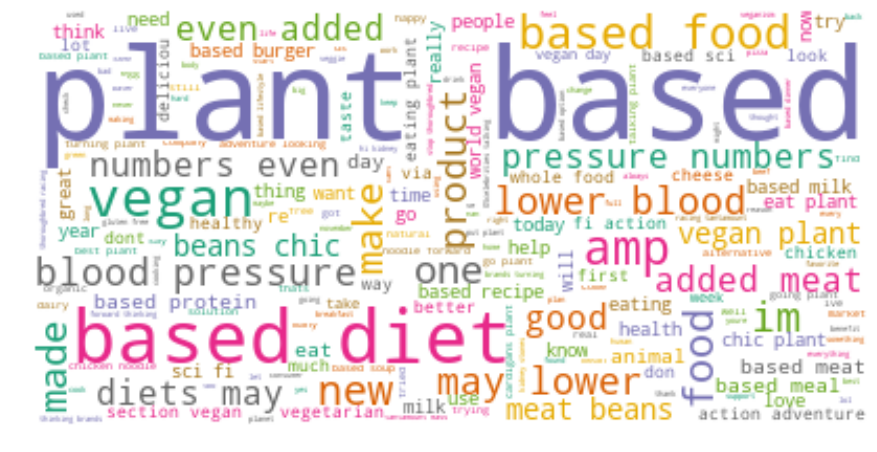

In [32]:
from wordcloud import WordCloud 

# word cloud visualization
allSentences = ' '.join([tweets for tweets in tweets['text']])
wordCloud = WordCloud(background_color='white', colormap='Dark2', max_font_size=150, random_state=1).generate(allSentences)
plt.figure(figsize = (15, 20))
plt.imshow(wordCloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [31]:
from textblob import TextBlob

# Create a function to get the subjectivity
def getSubjectivity(text):
   return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
   return  TextBlob(text).sentiment.polarity


# Create two new columns 'Subjectivity' & 'Polarity'
tweets['Subjectivity'] = tweets['text'].apply(getSubjectivity)
tweets['Polarity'] = tweets['text'].apply(getPolarity)

# Show the new dataframe with columns 'Subjectivity' & 'Polarity'
tweets

,text,Subjectivity,Polarity
5340,study quantifies game changing environmental e...,0.400000,-0.400000
5339,here are the top trends in and desserts,0.500000,0.500000
5338,if youre ever in london cant recommend this pl...,0.400000,0.500000
5337,if every single one of us who has compassion t...,0.157143,0.064286
5336,jeremy here the bad news about year ago my wif...,0.666667,-0.700000
...,...,...,...
4,i think wanna go plant based pescatarian meat ...,0.050000,0.000000
3,i eat plant based eat plant based eat plant ba...,0.000000,0.000000
2,ceo brings her values to work we re mission wi...,0.000000,0.000000
1,no ate indian and then after it for dessert ha...,0.000000,0.000000


In [33]:
# Create a function to compute negative (-1), neutral (0) and positive (+1) analysis
def getAnalysis(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

tweets['Analysis'] = tweets.Polarity.apply(getAnalysis)

tweets

,text,Subjectivity,Polarity,Analysis
5340,study quantifies game changing environmental e...,0.400000,-0.400000,Negative
5339,here are the top trends in and desserts,0.500000,0.500000,Positive
5338,if youre ever in london cant recommend this pl...,0.400000,0.500000,Positive
5337,if every single one of us who has compassion t...,0.157143,0.064286,Positive
5336,jeremy here the bad news about year ago my wif...,0.666667,-0.700000,Negative
...,...,...,...,...
4,i think wanna go plant based pescatarian meat ...,0.050000,0.000000,Neutral
3,i eat plant based eat plant based eat plant ba...,0.000000,0.000000,Neutral
2,ceo brings her values to work we re mission wi...,0.000000,0.000000,Neutral
1,no ate indian and then after it for dessert ha...,0.000000,0.000000,Neutral


In [34]:
# print all positive tweets
print('Positive tweets:\n')
j=1
sortedDf = tweets.sort_values(by=['Polarity'])
for i in range(0, sortedDf.shape[0]):
    if(sortedDf['Analysis'][i] == 'Positive'):
        print(str(j) + '. ' + sortedDf['text'][i])
        print()
        j+=1

Positive tweets:

1. new to the plant based lifestyle or long time vegan gone are the days of slim pickings for delectable desserts

2. some of the best busting foods also fit in plant based diet including vegan meal plan

3. honestly this plant based protein taste like ass dont recommend

4. been almost plant based for months amp have made and had some of the best food cant take away my sushi tho

5. as long as we dont have the full az count can still throw my plant based pizza in the oven right

6. vega sport protein its plant based and tasted soooo good buy the chocolate flavor and use water to m

7. today we welcome tennessee titans linebacker amp plant based chef to our fam as official beyond

8. plant based dinners are easy with read my review to learn more

9. hey folks its the holiday season so im going to be making plant based versions of my favorite dishes growing up w

10. ah shit and almost forgot been vegan well plant based for the past almost months its cool the food good

In [36]:
# print all negative tweets
print('Negative tweets:\n')
j=1
sortedDf = tweets.sort_values(by=['Polarity'])
for i in range(0, sortedDf.shape[0]):
    if(sortedDf['Analysis'][i] == 'Negative'):
        print(str(j) + '. ' + sortedDf['text'][i])
        print()
        j+=1

Negative tweets:

1. no plant based meat quite impressed me the way this impossible beef has join me as whip up an impossible beef

2. countries like india have heaps of poor farmers whose only non vegan consumption is milk but their weekly

3. theres plant based chicken its not the real deal but

4. is it real chicken or plant based chicken

5. considering cutting conventional dairy out of my diet but plant based cheese is not the move on texture

6. netherlands based firm nexusnovus wins contract to set up integrated solid waste management plant at bial

7. plant based will do that fuck keto try it for one week if you dont like how you feel or look so something different

8. noplant basedwhy something that requires animal exploitation when the other option which is al

9. i set new routines plant based diet and food diary ive done both on and off before lets see how long ill keeping them up this time

10. i wanna go plant based so bad

11. armaments he tend to use include redwood arm

In [37]:
# Print the percentage of positive tweets
ptweets = tweets[tweets.Analysis == 'Positive']
ptweets = ptweets['text']
ptweets

round( (ptweets.shape[0] / tweets.shape[0]) * 100 , 1)

46.6

In [38]:
# Print the percentage of negative tweets
negtweets = tweets[tweets.Analysis == 'Negative']
negtweets = negtweets['text']
negtweets

round( (negtweets.shape[0] / tweets.shape[0]) * 100 , 1)

13.6

In [39]:
# Print the percentage of neutral tweets
neutweets = tweets[tweets.Analysis == 'Neutral']
neutweets = neutweets['text']
neutweets

round( (neutweets.shape[0] / tweets.shape[0]) * 100 , 1)

39.8

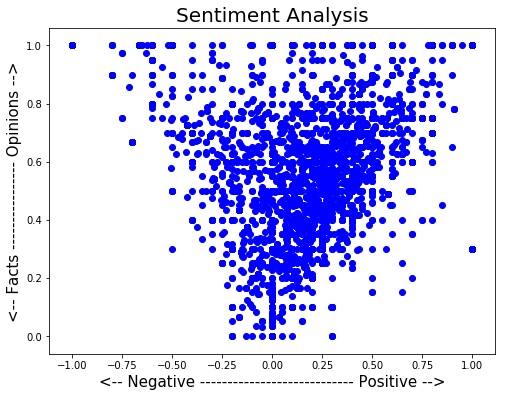

In [40]:
import matplotlib.pyplot as plt

# Plotting 
plt.figure(figsize=(8,6)) 
for i in range(0, tweets.shape[0]):
  plt.scatter(tweets["Polarity"][i], tweets["Subjectivity"][i], color='Blue') 

# plt.scatter(x,y,color)   
plt.title('Sentiment Analysis', fontsize=20)
plt.xlabel('<-- Negative ---------------------------- Positive -->', fontsize=15)
plt.ylabel('<-- Facts ---------------- Opinions -->', fontsize=15) 
plt.show()

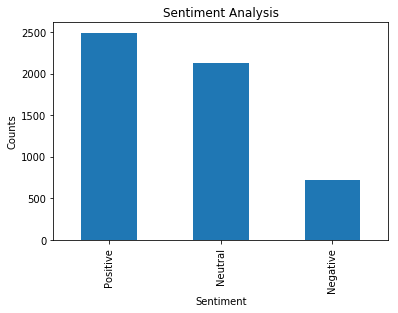

In [42]:
# Plotting and visualizing the counts
plt.title('Sentiment Analysis')
plt.xlabel('Sentiment')
plt.ylabel('Counts')
tweets['Analysis'].value_counts().plot(kind = 'bar')
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tv=TfidfVectorizer() 
tv_transform=tv.fit_transform(clean_description_lemmization)
# transfer to an array
tv_array = tv_transform.toarray()
tv_transform.shape